In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

In [2]:
# generate spikes on 4 different tetrodes
# each spike will have different amplitude, spike form, etc

In [3]:
a=np.zeros(64)
a[12:15]=0.3
a[18]=-5
a[25:27] = 0.15

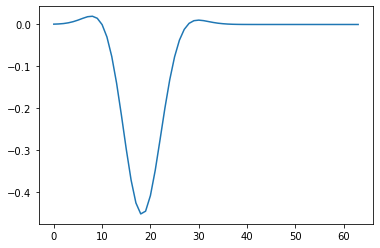

In [4]:
# plt.plot(np.convolve(np.exp(-np.arange(20)/2), a))
plt.plot(nd.gaussian_filter1d(a,4))

In [5]:
# one spike trace
def spike(ampl, width, bef, aft, sigm):
    w = int(width)
    a=np.zeros(64)
    a[30-w:32-w]=bef *ampl
    a[32]=-ampl
    a[32+w:35+w] = aft * ampl
    return nd.gaussian_filter1d(a,sigm)

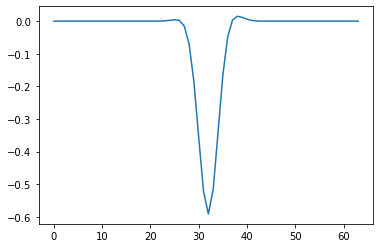

In [6]:
plt.plot(spike(3,3,0.01,0.02,2))

In [7]:
# ten cells: get random params
N = 10
np.random.seed(25)
ampls = 2*np.random.rand(N) + 0.5 # this then will be multiplied by
befs = np.random.rand(N)/5
afts = np.random.rand(N)/5
wids = np.random.randint(low=1, high = 4, size=N, dtype=int)
sigs = np.random.randn(N) + 3
# channel amplifs
chans = [np.random.rand(4)*2 + 0.5 for i in range(N)]

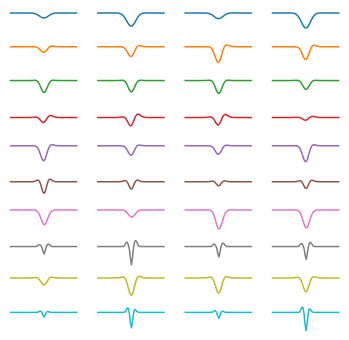

In [8]:
plt.figure(figsize=(6,6))
cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for i in range(N):
    spikes = [spike(ampls[i]*chans[i][j], wids[i], befs[i],afts[i],sigs[i]) for j in range(4)]
    for j in range(4):
        plt.subplot(N, 4, i*4 + j+1)
        plt.plot(spikes[j],c=cols[i])
        plt.axis('off')
        plt.ylim([np.min(spikes)-0.1, np.max(spikes)+0.1])

In [9]:
# random firing fields
np.random.seed(123)
cents = np.random.rand(N)
x=np.linspace(0,1,100)
ws = np.random.randint(low=10,high=30,size=N)
frs = np.random.randint(low=5,high=50,size=N) + np.random.rand(N)
tun = np.array([frs[ic]*np.exp(-ws[ic]*(x - c)**2) for ic,c in enumerate(cents)])

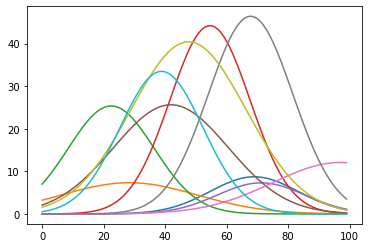

In [10]:
for i in range(N):
    plt.plot(tun[i])

In [ ]:
np.mean()

In [11]:
avg_sp = 20*np.exp(-30*(x - 0.5)**2) + 8

In [12]:
# simulate running - let's say 100 back and forths
locs = []
pos = 0
for tri in range(20):
    while pos<99:
        # jumps forward with a probability prop to avg_sp - let's say this is every 1ms
        pos = pos + int(np.random.rand()<avg_sp[pos]/1000)
        locs.append(pos)
    # random wait
    for i in range(np.random.randint(1000, 10000)):
        locs.append(pos)
    while pos>0:
        # jumps backward with a probability prop to avg_sp - let's say this is every 1ms
        pos = pos - int(np.random.rand()<avg_sp[pos]/1000)
        locs.append(pos)
    # random wait
    for i in range(np.random.randint(1000, 10000)):
        locs.append(pos)

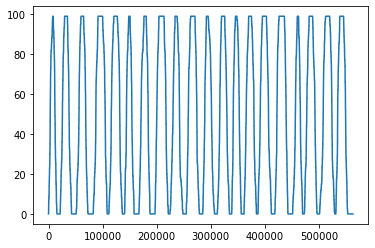

In [22]:
plt.plot(locs)

In [23]:
np.save('locs.npy',locs)

In [13]:
# simulate firing - add spikes to "LFP" trace
lfp=np.zeros([4, len(locs)*20],dtype=float)

In [14]:
spikes = np.array([[spike(ampls[i]*chans[i][j], 
                 wids[i], 
                 befs[i],
                 afts[i],
                 sigs[i]) for j in range(4)] for i in range(N)])

In [15]:
lfp.shape

(4, 11253220)

In [16]:
spikes.shape

(10, 4, 64)

In [17]:
fir = np.random.poisson(tun[:,locs]/1000)

In [18]:
np.sum(fir,1)

array([ 985, 1520, 3913, 2946,  900, 3182, 2681, 4852, 4956, 2788])

In [19]:
# add spikes + noise
for i in range(N):
    dels = np.random.randint(1,31,int(np.sum(fir[i])))
    for ii,n in enumerate(np.where(fir[i])[0]):
        ind = n*20 + dels[ii]
        lfp[:, ind-31:ind+33] = spikes[i] + np.random.randn(4,64)*0.001

In [20]:
np.save('fir.npy',fir)

In [20]:
# add oscillations and other, spurious things
osc_fr = 20000 / np.array([1,4,10,40,80,120,250])
ws = osc_fr/20000

In [21]:
osc = np.sum([0.2*np.sin(np.arange(len(lfp[0])) / o) for io,o in enumerate(osc_fr)],0)

In [22]:
np.max(osc)

1.153468866384038

In [23]:
from scipy import interpolate
# add background stuff
# noise = np.zeros_like(lfp)
for i in range(4):
    b = np.fft.irfft(np.random.randn(int(len(lfp[0])/8)), n=int(len(lfp[0])/4))
    f = interpolate.interp1d(np.arange(int(len(lfp[0])/4))*8,b,kind='cubic',fill_value='extrapolate')
    b_int = f(np.arange(len(lfp[0])))
    lfp[i] += osc/5 + b_int*25

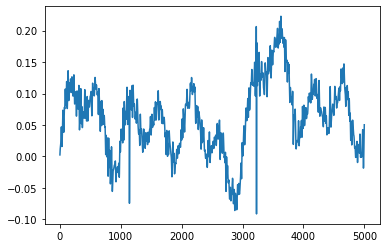

In [24]:
plt.plot(lfp[0][:5000])

In [25]:
2**16

65536

In [26]:
# resize from 0 to 65536
for i in range(4):
    lfp[i] = lfp[i] - np.min(lfp[i])
    lfp[i] = lfp[i] / np.max(lfp[i]) * 65536
lfp = lfp.astype(np.uint16)

In [27]:
binwrite=open('testint.in','wb')

In [28]:
lfp[0]

array([40842, 41014, 41154, ..., 42585, 42602, 42613], dtype=uint16)

In [29]:
np.sum(fir)

28723

In [30]:
lfp.tofile(binwrite)
binwrite.close()